# Анализ поведения пользователей мобильного приложения

## Описание проекта и данных

- Нужно разобраться, как ведут себя пользователи мобильного приложения: изучить воронку продаж и узнать, как пользователи доходят до покупки.
- Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, но для пользователей это может оказаться непривычно. Решение будет принято по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие:

*EventName* — название события;

*DeviceIDHash* — уникальный идентификатор пользователя;

*EventTimestamp* — время события;

*ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
display(data.head())
print(data.info())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


In [3]:
# В первую очередь переименуем столбцы
data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
# заменим тип данных в столбце с датой и временем
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
# добавим столбец с датой
data['date'] = data['event_timestamp'].dt.date
data['date'] = data['date'].astype('datetime64')
display(data.head())

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [4]:
# Посчитаем число пропусков и дубликатов
print('Пропуски:', data.isna().sum())
print()
print('Число дубликатов:', data.duplicated().sum())

Пропуски: event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
date               0
dtype: int64

Число дубликатов: 413


Пропуски отсутствуют, а количество дубликатов очень мало, поэтому можно их удалить.    

In [5]:
data = data.drop_duplicates().reset_index(drop=True)

## Изучение данных

In [6]:
# посмотрим, сколько всего событий в логе
print('Количество событий:', data.shape[0])
# также выясним количество уникальных пользователей в логе
print('Число пользователей:', data['device_id_hash'].nunique())
print('Среднее количество на одного пользователя:', round(data.shape[0]/data['device_id_hash'].nunique(), 2))

Количество событий: 243713
Число пользователей: 7551
Среднее количество на одного пользователя: 32.28


In [7]:
# далее определим, данными за какой период мы располагаем 
print('Начало периода', data['date'].min())
print('Конец периода', data['date'].max())

Начало периода 2019-07-25 00:00:00
Конец периода 2019-08-07 00:00:00


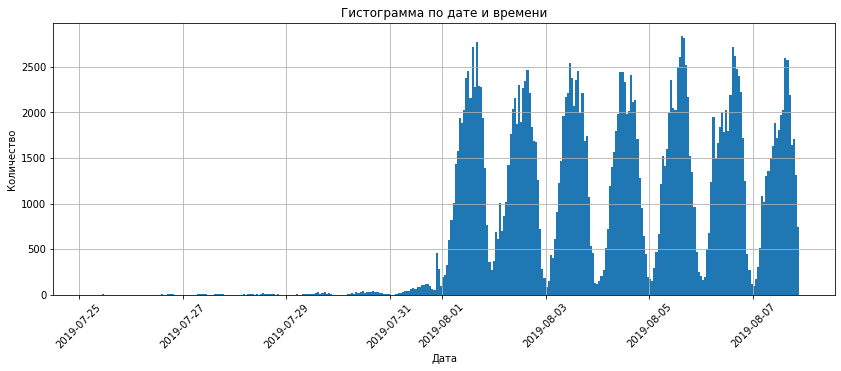

In [8]:
# постройм гистограмму по дате и времени, чтобы убедиться, что у нас одинаково полные данные за весь период
plt.figure(figsize=(9, 5))
data['event_timestamp'].hist(bins=14*24, figsize=(14, 5))
plt.xticks(rotation=45)
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

По гистограмме видно, что до 1 августа данные практически отсутствуют, скорее всего это несвоевременно дошедшие события за предыдущий период. Поэтому мы по сути распологаем данными только с 01.08.2019 по 07.08.2019.

In [9]:
# отсеим данные до 1 августа
data_new = data.query('date > "2019-07-31"')
# и посчитаем, сколько мы потеряли событий и пользователей
print('Число событий по очищенным данным:', data_new.shape[0],
     'Доля количества событий от изначального:', round(data_new.shape[0]/data.shape[0], 2))
print('Число пользователей по очищенным данным:',  data_new['device_id_hash'].nunique(),
     'Доля количества пользователей от изначального:', round(data_new['device_id_hash'].nunique() / data['device_id_hash'].nunique(), 3))

Число событий по очищенным данным: 240887 Доля количества событий от изначального: 0.99
Число пользователей по очищенным данным: 7534 Доля количества пользователей от изначального: 0.998


После отсеивания данных до 1 августа мы потеряли лишь 1% событий и 0.2% пользователей.

Далее проверим, что у нас представлены пользователи из всех трёх экспериментальных групп.

In [10]:
users_count = data_new.groupby('exp_id', as_index=True)['device_id_hash'].nunique()
users_count['246+247'] = users_count[246] + users_count[247]
users_count

exp_id
246        2484
247        2513
248        2537
246+247    4997
Name: device_id_hash, dtype: int64

Есть данные по всем трём группам

**Вывод:** было установлено, что мы обладаем полными данными лишь за период с 01.08.2019 по 07.08.2019, события и пользователи, предшествующие этому промежутку, были удалены без ущерба для данных. В очищенных данных присутсвует информация по всем трём экспериментальным группам.

## Изучение воронки событий

Посмотрим какие события есть в логах, как часто они встречаются. И отсортируем события по частоте.

In [11]:
print(data_new['event_name'].value_counts())

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


Посчитаем, сколько пользователей совершали каждое из этих событий и отсортируем события по числу пользователей. А также посчитаем долю пользователей, которые хоть раз совершали событие.

In [12]:
funnel_of_events = (data_new.groupby('event_name')
                    .agg({'event_name': 'count','device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
                   )
funnel_of_events.columns = ['events_count', 'users_count']
funnel_of_events['conversion'] = round(((funnel_of_events['users_count'] / data_new['device_id_hash'].nunique()) * 100), 1)
funnel_of_events = funnel_of_events.reset_index()
print(funnel_of_events)

                event_name  events_count  users_count  conversion
0         MainScreenAppear        117328         7419        98.5
1       OffersScreenAppear         46333         4593        61.0
2         CartScreenAppear         42303         3734        49.6
3  PaymentScreenSuccessful         33918         3539        47.0
4                 Tutorial          1005          840        11.1


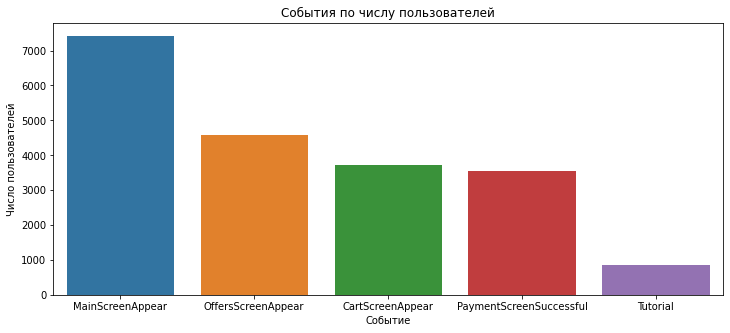

In [13]:
plt.figure(figsize=(12, 5))
sns.barplot(data=funnel_of_events, x='event_name', y='users_count')
plt.title('События по числу пользователей')
plt.xlabel('Событие')
plt.ylabel('Число пользователей')
plt.show()

События происходят в следующем порядке:
1. MainScreenAppear - пользователь попадает на главный экран
2. Tutorial - человеку предлагается пройти обучение
3. OffersScreenAppear - пользователь попадает на экран каталога
4. CartScreenAppear - переходит в корзину
5. PaymentScreenSuccessful - экран успешной оплаты заказа

Построим воронку событий, чтобы посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Этап Tutorial можно не учитывать в воронке, так как обучение не является обязательным и не влияет на то, дойдет ли пользователь до покупки.

In [25]:
# для начала построим таблицу, а затем визуализируем её
funnel_of_events_table = funnel_of_events.query('event_name != "Tutorial"')
funnel_of_events_table['prev_step'] = funnel_of_events_table['users_count'].shift()
funnel_of_events_table['step_conversion'] = round(funnel_of_events_table['users_count'] / funnel_of_events_table['prev_step'] * 100, 2)
funnel_of_events_table.drop(columns= ['prev_step'], axis = 1, inplace = True)
display(funnel_of_events_table)

funnel_of_events = funnel_of_events.query('event_name != "Tutorial"')
fig = go.Figure(go.Funnel(
    y = funnel_of_events['event_name'],
    x = funnel_of_events['users_count'],
    textinfo = "value + percent initial + percent previous"))
fig.show()

,event_name,events_count,users_count,conversion,step_conversion
0,MainScreenAppear,117328,7419,98.5,NaN
1,OffersScreenAppear,46333,4593,61.0,61.91
2,CartScreenAppear,42303,3734,49.6,81.30
3,PaymentScreenSuccessful,33918,3539,47.0,94.78


Самый большой спад конверсии - переход между главной страницей и страницей каталога - 38% пользователей до туда не доходят. Зато на следующих шагах - корзина и экран успешной оплаты - отсеивается всего 19% и 5% пользователей соответветственно. Всего до успешной оплаты доходят 48% пользователей приложения.

## Результаты эксперимента

Вспомним, сколько пользователей в каждой экспериментальной группе.

In [15]:
users_count

exp_id
246        2484
247        2513
248        2537
246+247    4997
Name: device_id_hash, dtype: int64

Проверим также количество пользователей, попавших более чем в одну группу для корректности проведения теста.

In [16]:
data_new.groupby('device_id_hash').agg({'exp_id': 'nunique'}).query('exp_id > 1').count()

exp_id    0
dtype: int64

Такие пользователи отсутствуют.

### A/A-тест

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Выберем самое популярное событие и посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Также посчитаем долю пользователей, совершивших это событие и проверим, будет ли отличие между группами статистически достоверным.**

Самое популярное событие - MainScreenAppear. Посмотрим доли пользователей, соврешивших это событие.

In [17]:
# создадим таблицу с количеством пользователей на каждое событие
event_groups = (
    data_new.query('event_name != "Tutorial"')
    .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
    .sort_values(by=246, ascending=False)
              )
event_groups['246+247'] = event_groups[246] + event_groups[247]

display(event_groups)

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [18]:
print('Доля пользователей 246 группы, совершившей событие "Главный экран":',
      round(event_groups.loc['MainScreenAppear', 246]/users_count[246], 3)
     )
print('Доля пользователей 247 группы, совершившей событие "Главный экран":',
    round(event_groups.loc['MainScreenAppear', 247]/users_count[247], 3))

Доля пользователей 246 группы, совершившей событие "Главный экран": 0.986
Доля пользователей 247 группы, совершившей событие "Главный экран": 0.985


Количество пользователей, попавших на главный экран, составило 2450 в 246 группе и 2476 в 247 группе, то есть 98.6% и 98.5% соответственно от общего числа пользователей. Проверим, равны ли группы статистически.

H0: Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

H1: Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [19]:
def z_test (group_1, group_2, alpha, event_name):
    alpha = alpha
    
    success_1 = event_groups.loc[event_name, group_1]
    success_2 = event_groups.loc[event_name, group_2]
    
    users_count_1 = users_count.loc[group_1]
    users_count_2 = users_count.loc[group_2]
    
    p1 = success_1 / users_count_1
    p2 = success_2 / users_count_2
    
    p_combined = (success_1 + success_2) / (users_count_1 + users_count_2)
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_count_1 + 1/users_count_2))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем H0')
    else:
        print('Не получилось отвергнуть H0')

In [20]:
z_test(246, 247, 0.01, 'MainScreenAppear')

p-значение:  0.7570597232046099
Не получилось отвергнуть H0


Гипотеза о равенстве групп по количеству пользователей, посетивших главный экран также не была отвергнута. Проведем тесты по всем событиям 246 и 247 групп. Аналогично сформулируем гипотезы

H0: Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

H1: Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [21]:
for event_name in event_groups.index:
    print(event_name)
    z_test(246, 247, 0.01, event_name)
    print()

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть H0

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть H0



**Мы видим, что нет статистически значимой разницы для всех событий воронки продаж в группах. То есть разбиение по группам прошло корректно.**

### A/B-тест

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. А также сравним результаты с объединённой контрольной группой.

In [22]:
groups = [246, 247, '246+247']

for n in groups:
    print('Группа', n, 'и группа 248')
    for event_name in event_groups.index:
        print(event_name)
        z_test(n, 248, 0.01, event_name)
        print()
    print('------------')    

Группа 246 и группа 248
MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть H0

PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть H0

------------
Группа 247 и группа 248
MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть H0

PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть H0

------------
Группа 246+247 и группа 248
MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть H0

PaymentScreenSu

**На всех уровнях воронки событий при проведении z-теста гипотеза о равенстве групп не была отвергнута. Группа, состоящая из суммы тестовых групп, также показала результаты в пользу равенства групп. Но мы провели 16 тестов, и при таком количестве возникает вероятность ошибки ложноположительного результата. Если мы хотим, чтобы групповая вероятность ошибки в данном случае не превышала уровень значимости α = 0.01, то, согласно методу Бонферрони, мы должны сравнить каждое из полученных p-value не с α, а с α/m, где m - число проверяемых гипотез. Применим поправку Бонферрони к коэффициенту статистической значимости и посмотрим на результат:**

In [23]:
# поделим alpha на 16
for event_name in event_groups.index:
    print(event_name)
    z_test(246, 247, 0.01/16, event_name)
    print()

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть H0

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть H0



In [24]:
groups = [246, 247, '246+247']

for n in groups:
    print('Группа', n, 'и группа 248')
    for event_name in event_groups.index:
        print(event_name)
        z_test(n, 248, 0.01/16, event_name)
        print()
    print('------------')  

Группа 246 и группа 248
MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть H0

PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть H0

------------
Группа 247 и группа 248
MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть H0

PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть H0

------------
Группа 246+247 и группа 248
MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть H0

OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть H0

CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть H0

PaymentScreenSu

**Применив поправку Бонферрони, мы получили результат, с большей вероятностью указывающий на то, что группы схожи между собой.**

## Вывод

В ходе исследования было установлено, что мы обладаем полными данными лишь за период с 01.08.2019 по 07.08.2019, события и пользователи, предшествующие этому промежутку, были удалены без ущерба для данных.

При построении воронки был исключён этап Tutorial, т.к он не является обязательным и не влияет на покупку. Также было обнаружено, что большая часть пользователей (38%) не идёт дальше главного экрана.

После проведения А/А-теста мы увидели, что нет статистически значимой разницы для всех событий воронки продаж в контрольных группах, то есть разбиение по группам прошло корректно. Но и гипотеза о сходстве контрольных и тестируемой групп не была опровергнута, это означает, что разница между поведением пользователей до изменения шрифта в приложении и после отсутствует. Шрифт можно не менять.